In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

#Aquatic Climate Variation: Modeling Lake Level Evaporation


# Introduction
**Motivation and Main Theme**
The Eddy Diffusion model simulates the seasonal variation in lake temperature and evaporation. This model sucessfully simulates thermal stratification in a variety of limnologic studies and has predicted both surface temperature and seasonal storage of heat.

**Importance**
Utilizing the Eddy Diffusion Model aids us in,


*   Understanding limnological seasonal variations
*   List item


**Methods Used: Crank-Nicklson and Finite Difference Method**
**Relation to Other Models**
#Equations
**Governing Equation**
To form a one-dimensional model:

$$
\frac{\partial T}{\partial t}
= \frac{1}{A(z)} \frac{\partial}{\partial z} \left\{ A(z)\,[\kappa_m + K(z,t)]\,\frac{\partial T}{\partial z} \right\} + \frac{1}{A(z)\,C_w} \frac{\partial \left[ \Phi A(z) \right]}{\partial z}
$$
**Terms, Variables, and Parameters**


*   Temperature $^{\circ}$: T
*   Time in days: t
*   Depth from the surface in meters: z
*   Lake Area at Depth z \$(m^2)$ : Az
*   Molecular Diffusivity \$(m^2 d^{-1})$ : Km
*   Eddy Diffusivity \$(m^2 d^{-1})$ : K(z,t)

*   Volumeteric heat capacity \$( J m^{-3} ^{\circ})$: C_w$

*  Heat Source Term \$( W m^{-2}) : $\Phi$


**Domain, Boundary Conditions, and Initial Conditions**
Domain:
Boundary Conditions:
The surface boundary condition couples with the balance of heat energy at the lake surface (0 to 0.6 m):
$$
[\kappa_m + K(z,t)]\,\frac{\partial T}{\partial z}
= K^* + L_d^* - L_u \pm Q_e \pm Q_h
$$

The bottom boundary condition for an insulated lake botttom:
$$
[\kappa_m + K(z,t)]\,\frac{\partial T}{\partial z} = 0
$$
**Numerical Methods**


In [ ]:
# ESM
# Introduction

#Using Crank Nicklson and Finite Difference Method

In [ ]:
#Initial Conditions and Equations
#T = temp in celcius
#t= time in days
#z = depth from surface m
#Az = lake area at depth z (m^2)
#Km = molecular diffusivity
#K(z,t) = eddy diffusivity
#Cw = volumeteric heat capacity
#Phi = heat source term (W/m^-2)

T = 20 # starting temp in Celsius
z = np.linspace(0, 100, 201)
dz = z[1] - z[0]              # vertical spacing
dt = 3600*24*7                # time step in seconds (e.g., 1 week in s)
t = 2*365*24*3600       # 2 years in seconds


Az = 430000 # lake area at depth, assuming it stays constant
Kappa_m = 0.01 # molecular diffusion of water (m^2 d^-1)
Cw = 4.138*10**6 #Jm^−3°C^−1
beta = 0.10 # proportion of shortwave radiation that is absorbed in the surface layer
eta = 0.3 # light extinction coefficient for water (m^-1)
K_star = 600 # net shortwave radiation at thewater surface (Wm^-2)
phi = (1-beta)*K_star*np.exp(-eta*z)

#Eddy Diffusion Coefficient
k = 0.4 # von Karman constant
U2 = 5 # wind speed at 2 m above water (m/s)
P0 = 1.0 # Neutral turbulent Prandtl number
w_star = 1.2e-3 * U2 # Surface friction velocity
latitude_deg = 40   # latitude for Lake Pyramid
phi_rad = np.radians(latitude_deg) # convert latitude to radians
k_star = 6.6 * (np.sin(phi_rad))**0.5 * U2**(-1.84) # Ekman profile decay parameter
T_k = 293.15

# Example temperature profile (linear decrease with depth) - NEED TO CHANGE
T_profile = T_k - 0.5 * z   # surface 293.15 K, decrease 0.5 K/m

g = 9.80665  # gravitational acceleration (m/s^2)
# density of freshwater
rho = (1 - 1.9549e-5 * np.abs(T_profile - 277)**1.68) * 1e3
# Density gradient
drho_dz = np.gradient(rho, z)
# Brunt-Väisälä frequency
N = np.sqrt(np.maximum(-g / rho * drho_dz, 0.0))
# Compute Ri using Henderson-Sellers parameterization
Ri =(-1.0 + np.sqrt(1 + (40 * N**2 * k**2 * z**2) / (w_star**2 * np.exp(-2 * k * z)))) / 20
# compute K
prefactor = (k * w_star * z) / P0
decay = np.exp(-k_star * z)
stab = 1.0 + 37.0 * Ri**2
K = prefactor * decay / stab

In [ ]:
#Governing Equation
# 1D vertical heat diffusion equation with eddy and molecular diffusion plus shortwave forcing

# Neumann boundary conditions (zero flux at top and bottom)

# finite/central difference (second order spatial derivative)
def dTdt(T_profile, K, Kappa_m, phi, Az, Cw, dz):
    dTdz = np.zeros_like(T_profile)  # use the input array T
    dTdz[1:-1] = (T_profile[2:] - T_profile[:-2]) / (2*dz)

    # Zero-flux boundaries
    dTdz[0] = 0
    dTdz[-1] = 0

    # Derivative of K
    dKdz = np.zeros_like(K)
    dKdz[1:-1] = (K[2:] - K[:-2]) / (2*dz)

    # Second derivative of T
    d2Tdz2 = np.zeros_like(T_profile)
    d2Tdz2[1:-1] = (T_profile[2:] - 2*T_profile[1:-1] + T_profile[:-2]) / dz**2

    # First term
    term1 = ((K + Kappa_m) * d2Tdz2 + dKdz * dTdz) / Az

    # Second term
    dphi_dz = np.zeros_like(phi)
    dphi_dz[1:-1] = (phi[2:] - phi[:-2]) / (2*dz)
    term2 = dphi_dz / Cw

    return term1 + term2

nsteps = int(t / dt)
for n in range(nsteps):
    dT = dTdt(T_profile, K, Kappa_m, phi, Az, Cw, dz)
    T_profile[1:-1] += dt * dT[1:-1]  # update interior points

#delta_T = (1/Az) * (deltaz)* (Az*(Kappa_m = K(z,t))*delta_T/delta_z)+ (1/Az)*(1/Cw)* ((delta(phi*Az))/delta_z)

In [ ]:
#Subsurface haring bu absorption of penetrating solar radiation
#phi = (1 - B)* (K** (e**-(nt))
#B = the proportion of shortwave radiation that is absorbed in the surface layer
#n = light extinction coefficent
#K* = net shortwave radiation at the water surface


In [ ]:
#heat energy at the lake surface eq
#top of the lake is the fort 0.6 m
#(km + k(z,t)) * delta_T/delta_z = K* + Ld -Lu + or - Qe + or - Q h
#Ld is the net long wave radiation from the atmosphere
#Lu is the long wave radiation from the lake surface
#Qe is the flux of the latent heat
# Qh is the flux of the sensible heat


In [ ]:
#bottom boundary condition for an insulated lake
#(Km + K(z,t))*delta_T/delta_z = 0


In [ ]:
#Eddy difussion stuff
#K(z)= ((k*w*z)/P0)e**(-k2*z)*(1+37*R*i**2)**-1
#k = 0.4
#w = the surface value of friction velocity
#P0 = 1.0
#k2 = the latitundianlly dependent parameter of the Elkman profile
#Ri = the gradient richardson number
#w = (1.2 * 10 **-3)*U2
#U2 = the wind speed above the water surface
#k2 = 6.6((sin(heat))**.5)*U2**-1.84
#Ri = ((-1 + (1 + 40*(N**2) *(k**2)* (z**2))/((w**2)e**-2k*z))**.5)/20
#N = [-g/p*(dp/dg)]**.5
#p = (1-1.9549 * 10**-5 |Tk -277|**1.69)* 10**3

DONE


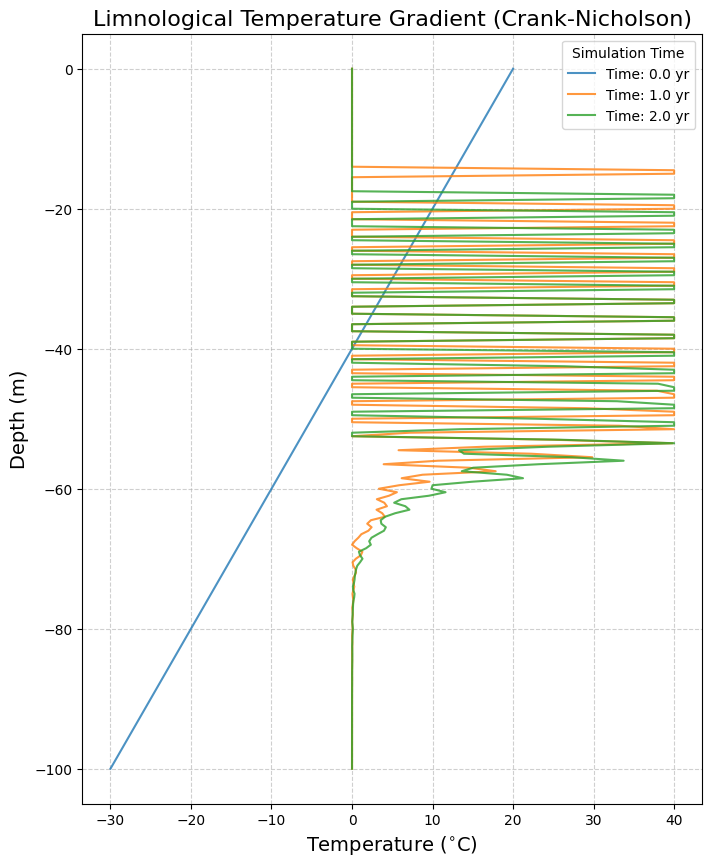

In [ ]:
#Crank Nicklson simulation
#Reimputting the parameters
#Simulation parameters constants
T_C= 20
T_K = T_C + 273.15
z_max = 100
n = 201
z = np.linspace(0, z_max, n)
dz = z[1] - z[0]
dt = 3600*24*7
t = 2*365*24*3600

#Physical Constants
Az = 430000
Kappa_m = 0.01 / (24 * 3600)
Cw = 4.138*10**6
g = 9.80665
latitude_deg = 40
phi_rad = np.radians(latitude_deg)

#Shortwave Radiation
beta = 0.10
eta = 0.3
K_star = 600
phi = (1-beta)*K_star*np.exp(-eta*z) #the instantaneous heat flux/irradiance at depth z
dphi_dz = np.gradient(phi, dz)
Source = - (1/Cw)*(dphi_dz) # using the heat diffusion convention

#Temperature Profile
T_profile = T_K - 0.5 * z # inital temp profile
T_history = [T_profile.copy()] #store inital state

#Calculating the diffusion coefficent (k)
def calculate_diffusivity(temp_prof):#calculates the Eddy Diffusion Coefficient K based on the temp profile
  #Wind constants
  k = 0.4 # von Karman constant
  U2 = 5 # wind speed at 2 m above water (m/s)
  P0 = 1.0 # Neutral turbulent Prandtl number
  w_star = 1.2e-3 * U2 # Surface friction velocity
  k_star = 6.6 * (np.sin(phi_rad))**0.5 * U2**(-1.84) # Ekman profile decay parameter

  #Density of freshwater(T has to be in C)
  rho = (1 - 1.9549e-5 * np.abs(temp_prof - 277)**1.68) * 1e3
  # Density gradient
  drho_dz = np.gradient(rho, z)

  #Brunt-Vaisla Frequency
  N2 = (np.maximum(-g / rho * drho_dz, 0.0))
  N = np.sqrt(N2)

  #Richardson Number using Henderson-Sellers parameterization
  z_stab = z + 1e-6

  numerator = 40 * N**2 * k**2 * z_stab**2
  denominator = w_star**2 * np.exp(-2 * k * z_stab)
  Ri = (-1.0 + np.sqrt(1 + numerator / denominator)) / 20

  #Computing K
  prefactor = (k * w_star * z_stab) / P0
  decay = np.exp(-k_star * z_stab)
  stab = 1.0 + 37.0 * Ri**2
  K_eddy = prefactor * decay / stab

  #Total Diffusivity
  D = Kappa_m + K_eddy
  return D

#The Crank Nicholoson step to solve A*T_new = b. A is the tridiagonal matrix, b is the RHS vector
def crank_nicholson_step(T_old,D_old,Source,dt,dz):
  N = len(T_old)
  alpha = dt / (2.0 * dz**2)

  # Calculate diffusivities at interfaces (mid-points)
  # D_interfaces[j] corresponds to D at z_{j+1/2} for j = 0, ..., N-2
  D_interfaces = (D_old[1:] + D_old[:-1]) / 2.0 # Length N-1

  # Initialize full N-length diagonal arrays
  main_diag = np.ones(N) # Main diagonal
  upper_diag = np.zeros(N) # Upper diagonal (coefficients for T_{i+1})
  lower_diag = np.zeros(N) # Lower diagonal (coefficients for T_{i-1})

  # Construct diagonals for interior points (i from 1 to N-2)
  # Main diagonal (A_ii)
  main_diag[1:-1] = 1.0 + alpha * (D_interfaces[1:] + D_interfaces[:-1])
  # Upper diagonal (A_i_i+1)
  upper_diag[1:-1] = -alpha * D_interfaces[1:]
  # Lower diagonal (A_i_i-1)
  lower_diag[1:-1] = -alpha * D_interfaces[:-1]

  # Applying Neumann Boundary Conditions
  # Top Boundary (i=0): Equation is set by 2 * D_0.5 * (T_1 - T_0) / dz^2
  # A_00 = 1 + 2*alpha*D_0.5, A_01 = -2*alpha*D_0.5
  D_0_5 = D_interfaces[0] # D at z_{0.5}
  main_diag[0] = 1.0 + 2.0 * alpha * D_0_5
  upper_diag[0] = -2.0 * alpha * D_0_5 # This is the coefficient for T_1 in the first equation

  # Bottom Boundary (i=N-1): Equation is set by -2 * D_{N-1/2} * (T_{N-1} - T_{N-2}) / dz^2
  # A_N-1_N-1 = 1 + 2*alpha*D_{N-1/2}, A_N-1_N-2 = -2*alpha*D_{N-1/2}
  D_N_1_5 = D_interfaces[-1] # D at z_{N-1.5}
  main_diag[-1] = 1.0 + 2.0 * alpha * D_N_1_5
  lower_diag[-1] = -2.0 * alpha * D_N_1_5 # This is the coefficient for T_{N-2} in the last equation

  # Tridiagonal Matrix in (c, a, b) format for the solve_banded package
  # ab[0, k] is for A[k, k+1] (upper diag)
  # ab[1, k] is for A[k, k] (main diag)
  # ab[2, k] is for A[k, k-1] (lower diag)
  ab = np.zeros((3, N))
  ab[1, :] = main_diag
  ab[0, :-1] = upper_diag[:-1] # A_{i,i+1} terms for i = 0 to N-2
  ab[2, 1:] = lower_diag[1:]   # A_{i,i-1} terms for i = 1 to N-1

  # Constructing the RHS vector
  L_T_old = np.zeros_like(T_old) # Initialize L_T_old
  # Interior points L_T_old[i] = 1/dz^2 * [D_{i+1/2} * T_old_{i+1} - (D_{i+1/2} + D_{i-1/2}) * T_old_i + D_{i-1/2} * T_old_{i-1}]
  L_T_old[1:-1] = (D_interfaces[1:] * T_old[2:] -
                     (D_interfaces[1:] + D_interfaces[:-1]) * T_old[1:-1] +
                     D_interfaces[:-1] * T_old[:-2]) / dz**2

  # Explicit boundary conditions for the RHS vector (these were symmetric in the original code, let's keep that structure)
  # Top boundary
  L_T_old[0] = 2.0 / dz**2 * D_interfaces[0] * (T_old[1] - T_old[0])
  # Bottom boundary
  L_T_old[-1] = 2.0 / dz**2 * D_interfaces[-1] * (T_old[-2] - T_old[-1])

  b = T_old + (dt / 2.0) * L_T_old + dt * Source
  T_new = solve_banded((1, 1), ab, b)
  return T_new


#Time Stepping loop
nsteps = int(t / dt)
for n_step_idx in range(nsteps):
  D = calculate_diffusivity(T_profile) #recalculating the rediffusivity
  T_profile = crank_nicholson_step(T_profile,D,Source,dt,dz) #doing the crank-nicholson step
  # Clip temperature to physical bounds (e.g., 0C to 40C) to prevent divergence and NaNs
  T_profile = np.clip(T_profile, 273.15, 313.15) # 273.15 K = 0 C, 313.15 K = 40 C

  if (n_step_idx + 1) % 52 == 0 or n_step_idx == nsteps -1:
    T_history.append(T_profile.copy())
print('DONE')

#Plotting
plt.figure(figsize=(8, 10))
num_snapshots = len(T_history)
years = np.linspace(0, t / (365*24*3600), num_snapshots)

# Plotting the thermal structure (Temperature vs. Depth)
for i, T_snap in enumerate(T_history):
    T_snap_C = T_snap - 273.15
    plt.plot(T_snap_C, -z, label=f'Time: {years[i]:.1f} yr', alpha=0.8)

plt.xlabel(r'Temperature ($^{\circ}$C)', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.title('Limnological Temperature Gradient (Crank-Nicholson)', fontsize=16)
plt.legend(title="Simulation Time")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()